In [1]:
import numpy as np
import pandas as pd
from soak_low_level import SOAK

In [2]:
dataset = 'WorkersCompensation'
target_col = 'UltimateIncurredClaimCost'
subset_col = 'Gender'

In [3]:
# Load data
data = np.genfromtxt(f'data/{dataset}.csv.xz', delimiter=',', dtype=None, names=True, encoding=None)
X = np.column_stack([data[name] for name in data.dtype.names if name.startswith('X_')])
y = data[target_col]
subset_vec = data[subset_col]

In [4]:
# initial soak obj
soak_obj = SOAK(n_splits=5)

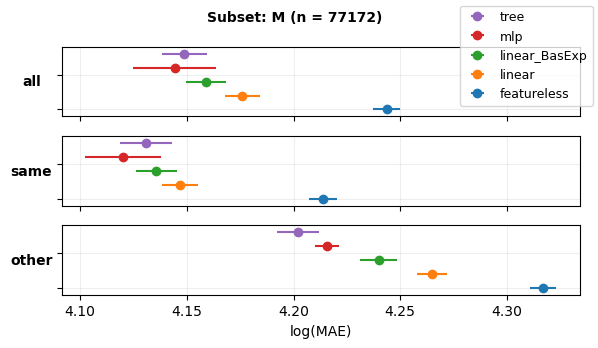

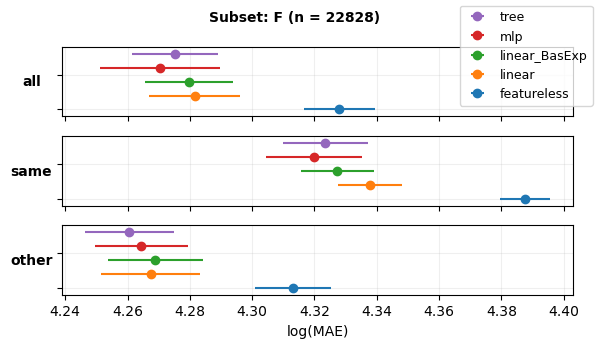

In [5]:
# generate dataframe of results:
results = []
for subset_value, category, X_train, y_train, X_test, y_test in soak_obj.split(X, y, subset_vec):
    for model in ['featureless', 'linear', 'linear_BasExp', 'tree', 'mlp']:
        mse, mae = soak_obj.model_eval(X_train, y_train, X_test, y_test, model)
        results.append({
                    "subset": subset_value,
                    "category": category,
                    "model": model,
                    "mse": mse,
                    "mae": mae,
                })
results_df = pd.DataFrame(results)

for value in ['M', 'F']:
    soak_obj.plot_metrics(results_df, value, subset_vec, metric='mae', figsize=(6,3.5))

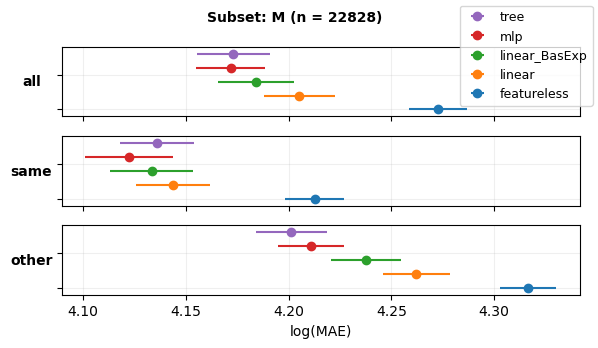

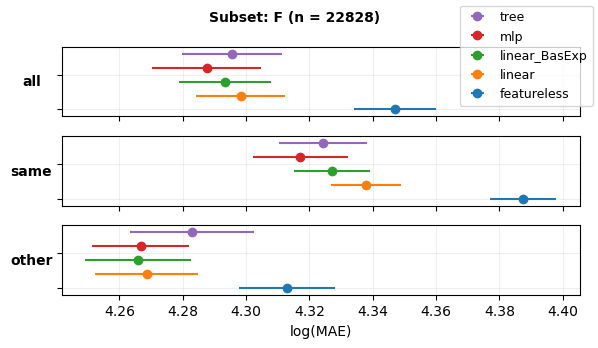

In [6]:
results_down = []
for seed in np.random.randint(1, 1000, 2):
    X_down, y_down, subset_vec_down = soak_obj.downsample_majority(X, y, subset_vec, seed)
    for subset_value, category, X_train, y_train, X_test, y_test in soak_obj.split(X_down, y_down, subset_vec_down):
        for model in ['featureless', 'linear', 'linear_BasExp', 'tree', 'mlp']:
            mse, mae = soak_obj.model_eval(X_train, y_train, X_test, y_test, model)
            results_down.append({
                        "subset": subset_value,
                        "category": category,
                        "model": model,
                        "mse": mse,
                        "mae": mae,
                    })
results_down_df = pd.DataFrame(results_down)

for value in ['M', 'F']:
    soak_obj.plot_metrics(results_down_df, value, subset_vec_down, metric='mae', figsize=(6,3.5))